# Phase 1 - Scoring Analysis

In [6]:
# --- Imports & Setup ---
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# Neo4j connection
URI  = "bolt://192.168.0.5:7687"
AUTH = ("neo4j", "PotatoDTND12!")
driver = GraphDatabase.driver(URI, auth=AUTH)

# Time windows (UTC−3)
APRIL_START_EPOCH = 1743476400  # 2025-04-01 00:00 (UTC−3)
APRIL_END_EPOCH   = 1746068400  # 2025-05-01 00:00 (UTC−3)

APRIL1_START = 1743476400       # 2025-04-01 00:00 (UTC−3)
APRIL1_END   = 1743562800       # 2025-04-02 00:00 (UTC−3)

print("Setup OK")


Setup OK


In [7]:

# --- Helpers ---
def sci(x, sig=6):
    """Format a float into 'x.xxxxxx × 10^n'."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "n/a"
    if x == 0:
        return f"{0:.{sig}f} × 10^0"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / (10**exp)
    return f"{mant:.{sig}f} × 10^{exp}"

def one_minus_ws(df, score_col="scoring", label_col="label"):
    """Compute 1−WS similarity and normalized WS distance between anomaly (1) and normal (0)."""
    if df.empty or df[label_col].nunique() < 2:
        return {"one_minus_ws": np.nan, "ws": np.nan}
    a = df.loc[df[label_col]==1, score_col].astype(float).values
    b = df.loc[df[label_col]==0, score_col].astype(float).values
    if len(a)==0 or len(b)==0:
        return {"one_minus_ws": np.nan, "ws": np.nan}
    ws = wasserstein_distance(a, b)
    lo = float(np.nanmin(np.concatenate([a,b])))
    hi = float(np.nanmax(np.concatenate([a,b])))
    rng = max(hi - lo, 1e-12)
    ws_norm = ws / rng
    sim = 1.0 - max(0.0, min(1.0, ws_norm))
    return {"one_minus_ws": sim, "ws": ws_norm}

def fetch_phase1_scores(start_epoch, end_epoch):
    q = """
MATCH (tx:Transaction)
WHERE tx.scoring IS NOT NULL AND tx.label IS NOT NULL
  AND tx.timestamp >= $startEpoch AND tx.timestamp < $endEpoch
RETURN toFloat(tx.scoring) AS scoring, toInteger(tx.label) AS label
"""
    with driver.session() as s:
        rows = [dict(r) for r in s.run(q, startEpoch=start_epoch, endEpoch=end_epoch)]
    return pd.DataFrame(rows)

def describe_window(df):
    if df.empty:
        return {"n":0, "anom_rate":0.0, "anom_min":None, "anom_max":None, "norm_min":None, "norm_max":None}
    n = len(df)
    anom = df[df.label==1]["scoring"].astype(float)
    norm = df[df.label==0]["scoring"].astype(float)
    anom_rate = len(anom) / max(1,n)
    return {
        "n": n,
        "anom_rate": anom_rate,
        "anom_min": float(np.nanmin(anom)) if len(anom)>0 else None,
        "anom_max": float(np.nanmax(anom)) if len(anom)>0 else None,
        "norm_min": float(np.nanmin(norm)) if len(norm)>0 else None,
        "norm_max": float(np.nanmax(norm)) if len(norm)>0 else None,
    }

def plot_hist(df, title):
    if df.empty:
        print("No data for", title); return
    plt.figure(figsize=(8,5))
    plt.hist(df.loc[df.label==0, "scoring"], bins=100, alpha=0.6, label="Normal (0)", density=True)
    plt.hist(df.loc[df.label==1, "scoring"], bins=100, alpha=0.6, label="Anomaly (1)", density=True)
    plt.axvline(0, linestyle="--", linewidth=0.8)
    plt.title(title); plt.xlabel("IsolationForest decision score"); plt.ylabel("Density"); plt.legend(); plt.show()


In [8]:

# --- Run (Phase 1 only) ---
apr1_df = fetch_phase1_scores(APRIL1_START, APRIL1_END)
apr_df  = fetch_phase1_scores(APRIL_START_EPOCH, APRIL_END_EPOCH)

apr1_stats = describe_window(apr1_df)
apr_stats  = describe_window(apr_df)

apr1_sim = one_minus_ws(apr1_df)
apr_sim  = one_minus_ws(apr_df)

print("Fetched:", len(apr1_df), "(April 1st),", len(apr_df), "(April 2025)")


Fetched: 62758 (April 1st), 3675439 (April 2025)


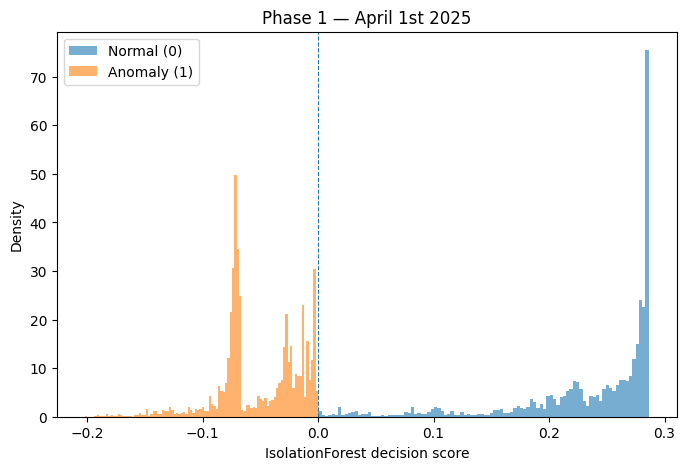

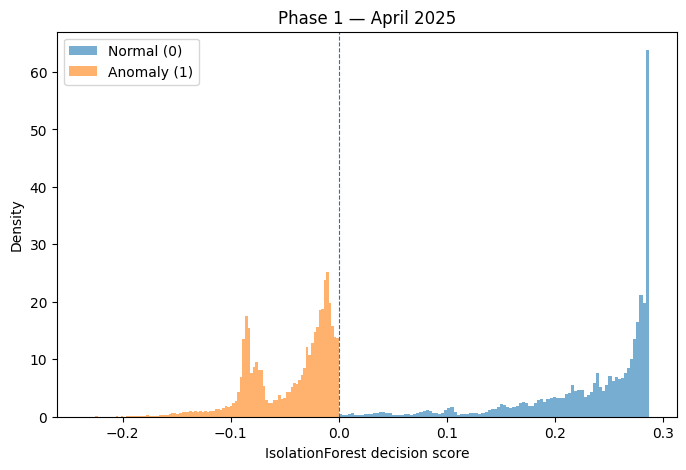

In [9]:

# Plots
plot_hist(apr1_df, "Phase 1 — April 1st 2025")
plot_hist(apr_df,  "Phase 1 — April 2025")


In [10]:

# --- Table print (scientific notation + 1−WS) ---
def row(period, stats, sim):
    return {
        "Period": period,
        "#Tx": stats["n"],
        "Anomaly Rate": stats["anom_rate"],
        "Anomaly Min Score": sci(stats["anom_min"]),
        "Anomaly Max Score": sci(stats["anom_max"]),
        "Normal Min Score": sci(stats["norm_min"]),
        "Normal Max Score": sci(stats["norm_max"]),
        "1−WS Similarity": sim.get("one_minus_ws"),
        "WS Distance (norm)": sim.get("ws"),
    }

tbl = pd.DataFrame([
    row("April 1st 2025", apr1_stats, apr1_sim),
    row("April 2025",     apr_stats,  apr_sim),
])

print("Table — Phase 1 (1−WS, scientific notation)")
print(tbl.to_string(index=False))

#tbl.to_csv("/mnt/data/Scoring_Phase1_converted_1WS_table.csv", index=False)
#print("\nSaved: /mnt/data/Scoring_Phase1_converted_1WS_table.csv")


Table — Phase 1 (1−WS, scientific notation)
        Period     #Tx  Anomaly Rate Anomaly Min Score Anomaly Max Score Normal Min Score Normal Max Score  1−WS Similarity  WS Distance (norm)
April 1st 2025   62758      0.072915 -2.018440 × 10^-1 -7.974794 × 10^-5 1.530396 × 10^-4 2.863329 × 10^-1         0.410097            0.589903
    April 2025 3675439      0.052471 -2.346918 × 10^-1 -7.530230 × 10^-7 2.851699 × 10^-6 2.864268 × 10^-1         0.464757            0.535243
